# Traitement données texte 

In [283]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.image import imread
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics, preprocessing, manifold, decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.sparse import csr_matrix
sp = spacy.load('en_core_web_lg')
from os import listdir
import time

In [3]:
#Import du fichier contenant les données dans un dataframe df
df = pd.read_csv('Data/sample_1050.csv')

Définition des catégories de niveau d'arborescence 1 et 2

In [4]:
test = df['product_category_tree'].str.lstrip('["').str.split(' >>')
category = test.apply(lambda x:x[0])
category_2 = test.apply(lambda x:x[1])

In [382]:
category.value_counts()

Baby Care                     150
Watches                       150
Computers                     150
Kitchen & Dining              150
Beauty and Personal Care      150
Home Furnishing               150
Home Decor & Festive Needs    150
Name: product_category_tree, dtype: int64

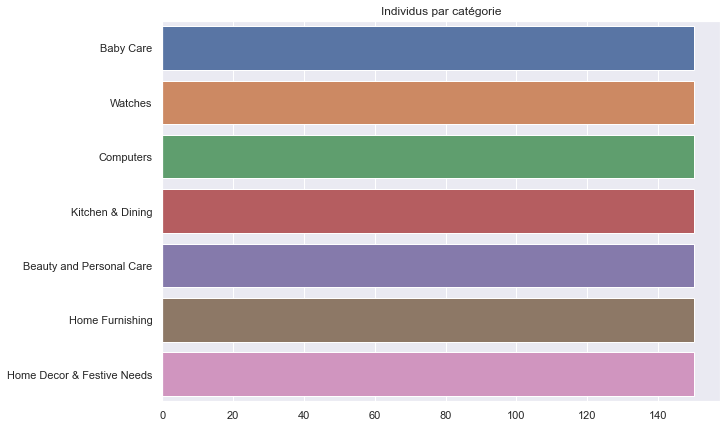

In [381]:
sns.set(rc={'figure.figsize':(10,7)})
g=sns.barplot(x=category.value_counts().values,y=category.value_counts().index)
g.set(title='Individus par catégorie');

In [97]:
category_2.value_counts()

 Wrist Watches                149
 Laptop Accessories            87
 Infant Wear                   84
 Coffee Mugs                   74
 Showpieces                    71
                             ... 
 Software                       1
 Beauty Accessories             1
 Strollers & Activity Gear      1
 Garden & Leisure               1
 Consumables & Disposables      1
Name: product_category_tree, Length: 63, dtype: int64

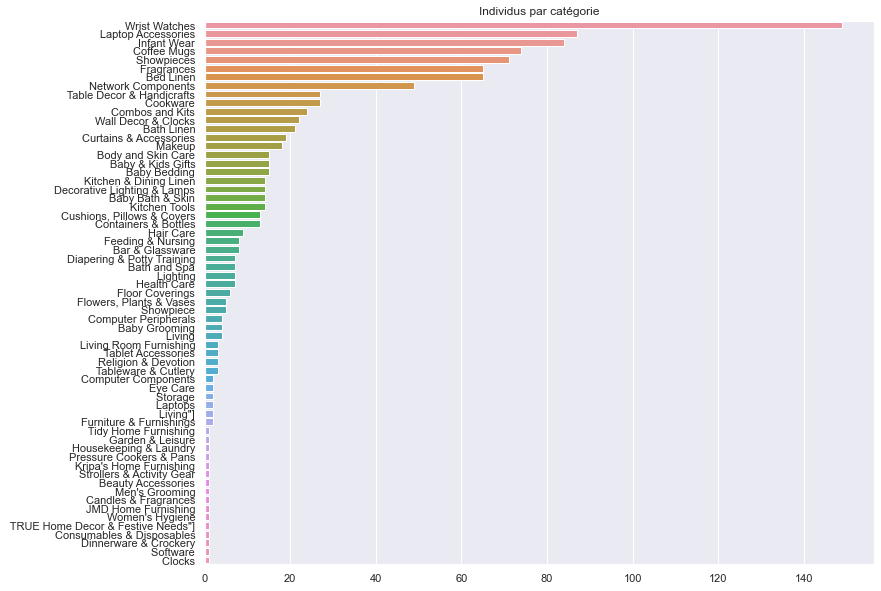

In [385]:
sns.set(rc={'figure.figsize':(12,10)})
g=sns.barplot(x=category_2.value_counts().values,y=category_2.value_counts().index)
g.set(title='Individus par catégorie');

Définition des variables texte (noms et descriptions) des produits (+ passage en minuscule)

In [31]:
names = df['product_name'].str.lower()

In [32]:
descriptions = df['description'].str.lower()

Nettoyage des variables texte

In [33]:
names_cleaned = names.apply(lambda x:[token for token in sp(x) if not token.is_punct]) # tokenisation
names_cleaned = names_cleaned.apply(lambda x: [word for word in x if not word.is_stop]) # Suppression des stopwords
names_cleaned = names_cleaned.apply(lambda x: [word.lemma_ for word in x]) # lemmatisation

In [34]:
descriptions_cleaned = descriptions.apply(lambda x:[token for token in sp(x) if not token.is_punct]) # tokenisation
descriptions_cleaned = descriptions_cleaned.apply(lambda x: [word for word in x if not word.is_stop]) # Suppression des stopwords
descriptions_cleaned = descriptions_cleaned.apply(lambda x: [word.lemma_ for word in x]) # lemmatisation

In [35]:
# Jointure des 2 variables
desc_joined = descriptions_cleaned + names_cleaned

### Bag of words et Tf-Idf

In [386]:
vectorizer = CountVectorizer(lowercase=False)
data = desc_joined.apply(lambda x: ' '.join([word for word in x]))
X = vectorizer.fit_transform(data.values).todense()

In [37]:
vectorizer = TfidfVectorizer(lowercase=False)
data = desc_joined.apply(lambda x: ' '.join([word for word in x]))
X_tf = vectorizer.fit_transform(data.values).todense()

Visualisation via TSNE des features BOW et Tf-Idf 

In [109]:
X_embedded = TSNE(n_components=2).fit_transform(X)

In [110]:
Xtf_embedded = TSNE(n_components=2).fit_transform(X_tf)

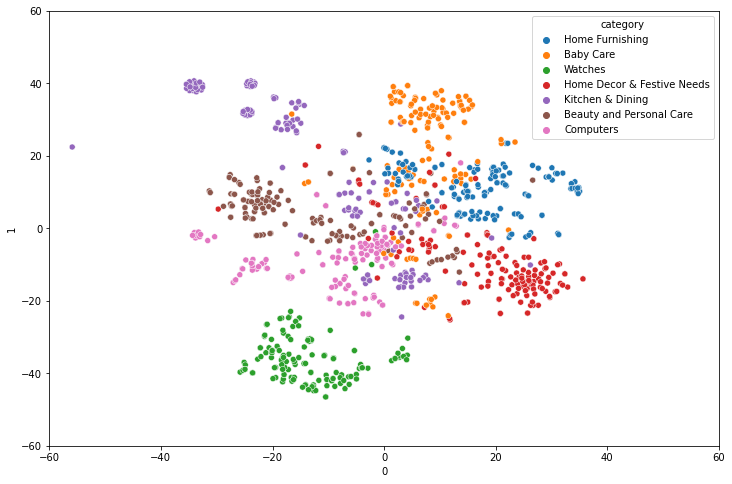

In [111]:
data=pd.DataFrame(X_embedded)
data['category']=category
plt.figure(figsize=(12,8));
sns.scatterplot(data=data,x=data[0],y=data[1],hue='category');
plt.ylim(-60,60);
plt.xlim(-60,60);

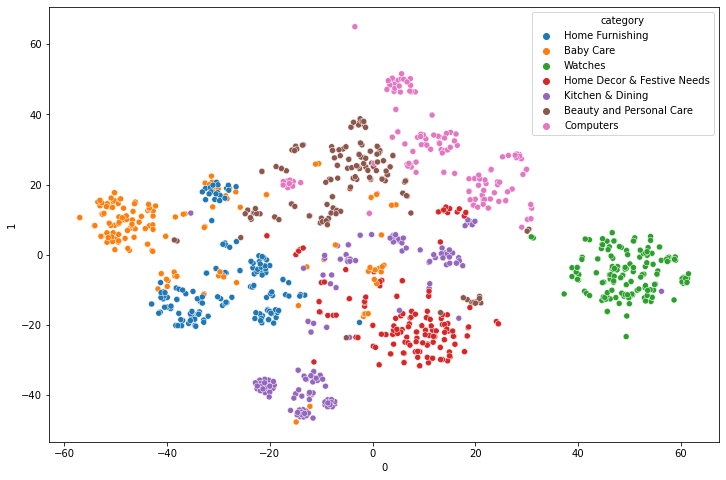

In [112]:
data=pd.DataFrame(Xtf_embedded)
data['category']=category
plt.figure(figsize=(12,8));
sns.scatterplot(data=data,x=data[0],y=data[1],hue='category');

### Nettoyage supplémentaire des termes les plus utilisés et non pertinents

In [38]:
all_words = [item for sublist in desc_joined for item in sublist]

In [39]:
unique, counts = np.unique(all_words, return_counts=True)

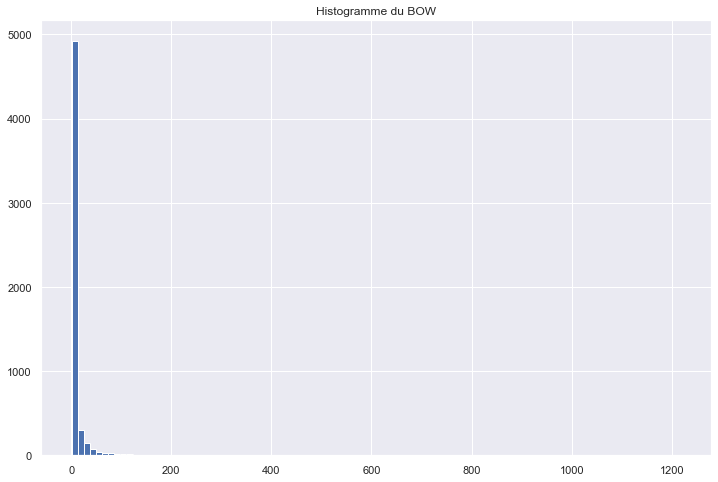

In [394]:
data=dict(zip(unique, counts)).values()
plt.figure(figsize=(12,8));
plt.hist(x=data,bins=100);
plt.title('Histogramme du BOW');

In [41]:
words_to_delete = ['\r',',','-','+','.','/',' ','"']
mydict = {key:val for key, val in dict(zip(unique, counts)).items() if val != max(dict(zip(unique, counts)).values())}
mydict = {key:val for key,val in mydict.items() if key[0] not in words_to_delete}

In [44]:
desc_joined_clean=desc_joined.apply(lambda x:[word for word in x if word in list(mydict.keys())])

In [45]:
vectorizer = CountVectorizer(lowercase=False)
data = desc_joined_clean.apply(lambda x: ' '.join([word for word in x]))
X_clean = vectorizer.fit_transform(data.values).todense()

In [312]:
vectorizer = TfidfVectorizer(lowercase=False)
data = desc_joined_clean.apply(lambda x: ' '.join([word for word in x]))
X_clean_tf = vectorizer.fit_transform(data.values).todense()

Visualisation des features par catégorie

In [124]:
X_clean_embedded = TSNE(n_components=2).fit_transform(X_clean)

In [129]:
Xtf_clean_embedded = TSNE(n_components=2).fit_transform(X_clean_tf)

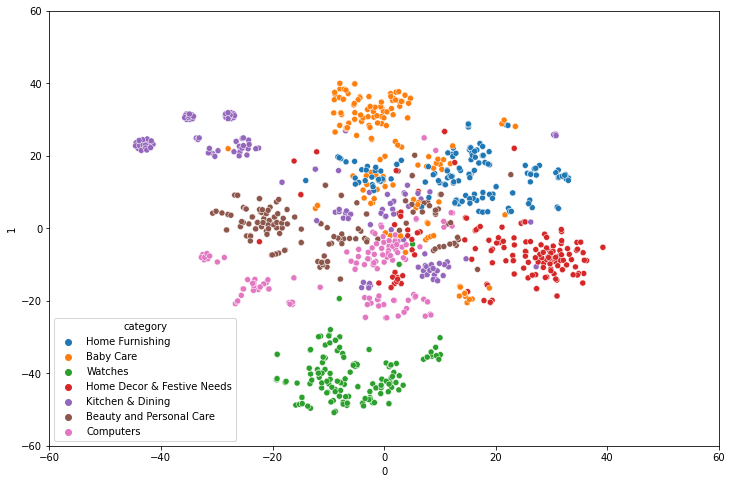

In [126]:
data=pd.DataFrame(X_clean_embedded)
data['category']=category
plt.figure(figsize=(12,8));
sns.scatterplot(data=data,x=data[0],y=data[1],hue='category');
plt.ylim(-60,60);
plt.xlim(-60,60);

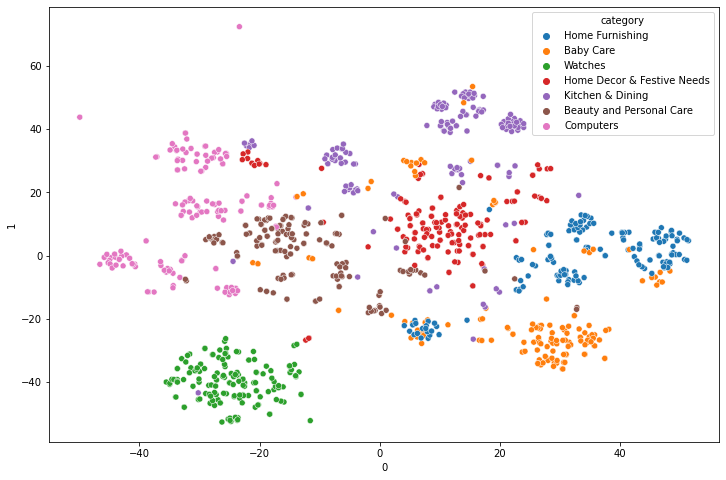

In [130]:
data=pd.DataFrame(Xtf_clean_embedded)
data['category']=category
plt.figure(figsize=(12,8));
sns.scatterplot(data=data,x=data[0],y=data[1],hue='category');

## Clustering des variables cleaned (BOW et Tf_Idf)

In [49]:
# Clustering BOW avec 7 catégories
kmeans = KMeans(n_clusters=7).fit(X_clean)
labels = kmeans.labels_
metrics.adjusted_rand_score(category,labels)

0.15276926757731707

In [327]:
# Clustering Tf-Idf avec 7 catégories
kmeans = KMeans(n_clusters=7).fit(X_clean_tf)
labels_tf = kmeans.labels_
metrics.adjusted_rand_score(category,labels_tf)

0.30747956008901

In [328]:
pca = decomposition.PCA(n_components=0.9)
X_clean_tf_pca = pca.fit_transform(X_clean_tf)

In [396]:
kmeans = KMeans(n_clusters=7).fit(X_clean_tf_pca)
labels_tf_pca = kmeans.labels_
metrics.adjusted_rand_score(category,labels_tf_pca)

0.3397387483688119

In [406]:
X_clean_pca_embedded = TSNE(n_components=2).fit_transform(X_clean_tf_pca)

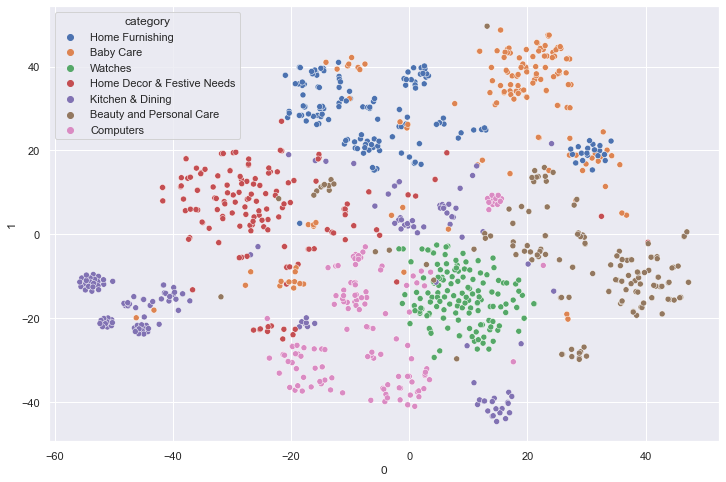

In [407]:
data=pd.DataFrame(X_clean_pca_embedded)
data['category']=category
plt.figure(figsize=(12,8));
sns.scatterplot(data=data,x=data[0],y=data[1],hue='category');

In [405]:
# Clustering Tf_Idf avec 63 catégories
kmeans = KMeans(n_clusters=63).fit(X_clean_tf_pca)
labels = kmeans.labels_
metrics.adjusted_rand_score(category_2,labels)

0.27483875523256923

## Random Forest des variables cleaned

In [409]:
X_train,X_test,X_tf_pca_train,X_tf_pca_test,y_train,y_test=train_test_split(X_clean,X_clean_tf_pca,category,test_size=0.3, random_state=0)
X_tf_train,X_tf_test=train_test_split(X_clean_tf,test_size=0.3, random_state=0)

In [361]:
model_gs_tf = GridSearchCV(estimator = RandomForestClassifier(random_state = 0, n_estimators = 500), param_grid={'max_depth': range(9,32,2)}, cv=5)      # définition de la Cross-Validation
        
model_gs_tf.fit(X_tf_pca_train, y_train) #Fit du modèle sur le jeu d'entrainement
print('Score :', model_gs_tf.score(X_tf_pca_test,y_test))
print('Paramètres : ', model_gs_tf.best_params_)   # Détermination des meilleurs paramètres

Score : 0.9015873015873016
Paramètres :  {'max_depth': 19}


In [414]:
model_gs = GridSearchCV(estimator = RandomForestClassifier(random_state = 0, n_estimators = 500), param_grid={'max_depth': range(9,32,2)}, cv=5)      # définition de la Cross-Validation
        
model_gs.fit(X_tf_train, y_train) #Fit du modèle sur le jeu d'entrainement
print('Score :', model_gs.score(X_tf_test,y_test))
print('Paramètres : ', model_gs.best_params_)   # Détermination des meilleurs paramètres

Score : 0.9111111111111111
Paramètres :  {'max_depth': 29}


In [415]:
model_gs = GridSearchCV(estimator = RandomForestClassifier(random_state = 0, n_estimators = 500), param_grid={'max_depth': range(9,32,2)}, cv=5)      # définition de la Cross-Validation
        
model_gs.fit(X_train, y_train) #Fit du modèle sur le jeu d'entrainement
print('Score :', model_gs.score(X_test,y_test))
print('Paramètres : ', model_gs.best_params_)   # Détermination des meilleurs paramètres

Score : 0.9111111111111111
Paramètres :  {'max_depth': 31}


In [362]:
y_train_2, y_test_2 = train_test_split(category_2,test_size=0.3, random_state=0)

In [364]:
model_gs = GridSearchCV(estimator = RandomForestClassifier(random_state = 0, n_estimators = 500), param_grid={'max_depth': range(9,32,2)}, cv=5)      # définition de la Cross-Validation
        
model_gs.fit(X_tf_train, y_train_2) #Fit du modèle sur le jeu d'entrainement
print('Score :', model_gs.score(X_tf_test,y_test_2))
print('Paramètres : ', model_gs.best_params_)   # Détermination des meilleurs paramètres

C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Score : 0.8095238095238095
Paramètres :  {'max_depth': 25}


## Vectorisation via méthodes Word2Vec et Doc2Vec

In [419]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts

In [420]:
# Définition du corpus d'entrainement puis du modèle
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
model = Doc2Vec(documents, vector_size=300, window=2, min_count=1, workers=4)

In [421]:
# Vectorisation via Doc2vec
vector_d2v = desc_joined_clean.apply(lambda x: model.infer_vector(x))

In [424]:
# Vectorisation via Word2Vec (Vecteur moyen de chaque mot)
vector_w2v = desc_joined_clean.apply(lambda y: np.mean(list(map(lambda x: sp(x).vector,y)),axis=0))

### Clustering sur ces vecteurs

In [422]:
data = pd.DataFrame(vector_d2v)
data_v = pd.DataFrame(data.iloc[:,0].to_list())
kmeans = KMeans(n_clusters=7)
kmeans.fit(data_v)
labels = kmeans.labels_

In [423]:
metrics.adjusted_rand_score(category,labels)

0.0018897691246974012

In [425]:
data = pd.DataFrame(vector_w2v)
data_w = pd.DataFrame(data.iloc[:,0].to_list())
kmeans = KMeans(n_clusters=7)
kmeans.fit(data_w)
labels_w2v = kmeans.labels_

In [426]:
metrics.adjusted_rand_score(category,labels_w2v)

0.36731916339436665

### Visualisation via TSNE

In [65]:
w2v_embedded = TSNE(n_components=2).fit_transform(data_w)

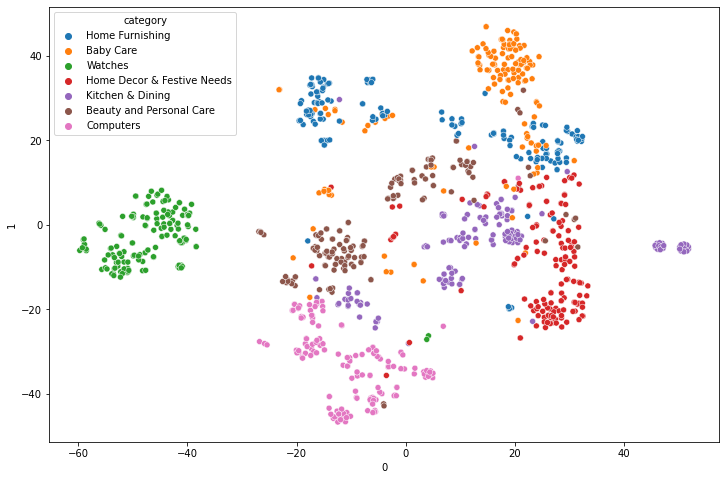

In [66]:
data=pd.DataFrame(w2v_embedded)
data['category']=category
data['km_labels']=labels_w2v
plt.figure(figsize=(12,8));
sns.scatterplot(data=data,x=data[0],y=data[1],hue='category');

### Random Forest sur les vecteurs issus de Word2Vec

In [67]:
data_v_train,data_v_test,data_w_train,data_w_test=train_test_split(data_v,data_w,test_size=0.3, random_state=0)

In [68]:
model_gs = GridSearchCV(estimator = RandomForestClassifier(random_state=0, n_estimators = 500), param_grid={'max_depth': range(9,32,2)})      # définition de la Cross-Validation
        
model_gs.fit(data_w_train, y_train) #Fit du modèle sur le jeu d'entrainement
print('Score :', model_gs.score(data_w_test,y_test))
print('Paramètres : ', model_gs.best_params_)   # Détermination des meilleurs paramètres

Score : 0.8984126984126984
Paramètres :  {'max_depth': 13}


In [71]:
model_gs_2 = GridSearchCV(estimator = RandomForestClassifier(random_state=0, n_estimators = 500), param_grid={'max_depth': range(9,32,2)})      # définition de la Cross-Validation
        
model_gs_2.fit(data_w_train, y_train_2) #Fit du modèle sur le jeu d'entrainement
print('Score :', model_gs_2.score(data_w_test,y_test_2))
print('Paramètres : ', model_gs_2.best_params_)   # Détermination des meilleurs paramètres

C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Score : 0.8063492063492064
Paramètres :  {'max_depth': 25}


# Traitement données images

In [285]:
import cv2 as cv

In [286]:
path = "C:\\Users\\BENAVEN\\Desktop\\Stevan\\Formation OCR\\Projet 6 - Classifiez automatiquement des biens de consommation\\Data\\Images\\"
list_photos = [file for file in listdir(path)]

In [287]:
#Création d'un dataframe contenant le chemin et le nom des images
data = pd.DataFrame()
data["image_path"] = list_photos
data["label_name"] = data["image_path"].apply(lambda x : category[df[df['image']==x].index].values[0])

In [288]:
data.groupby("label_name").count()

,image_path
label_name,
Baby Care,150
Beauty and Personal Care,150
Computers,150
Home Decor & Festive Needs,150
Home Furnishing,150
Kitchen & Dining,150
Watches,150


Watches


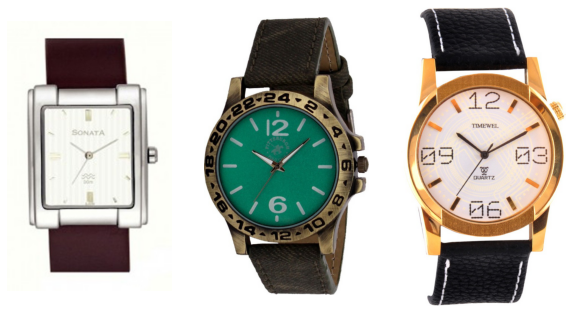

--------------------------------------
Kitchen & Dining


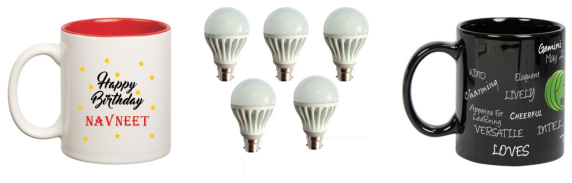

--------------------------------------
Home Furnishing


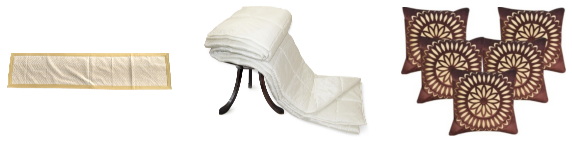

--------------------------------------
Beauty and Personal Care


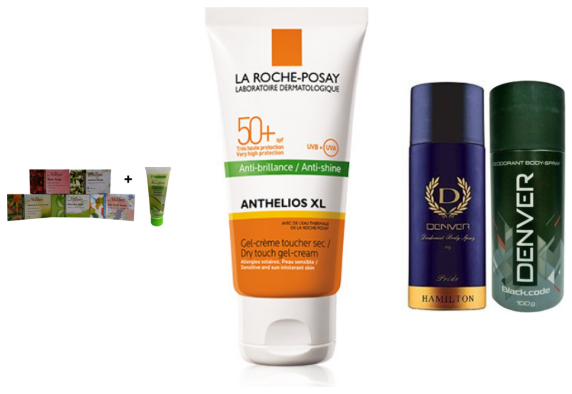

--------------------------------------
Computers


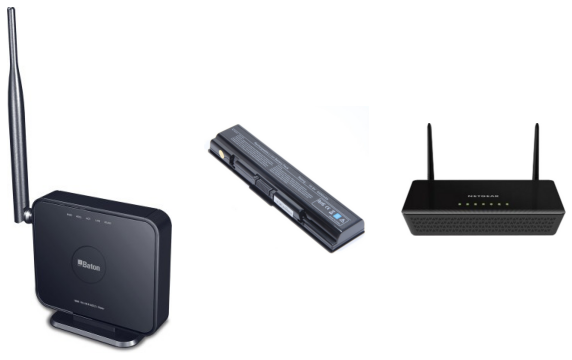

--------------------------------------
Home Decor & Festive Needs


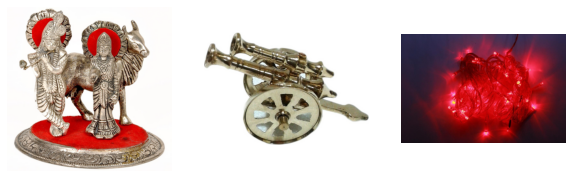

--------------------------------------
Baby Care


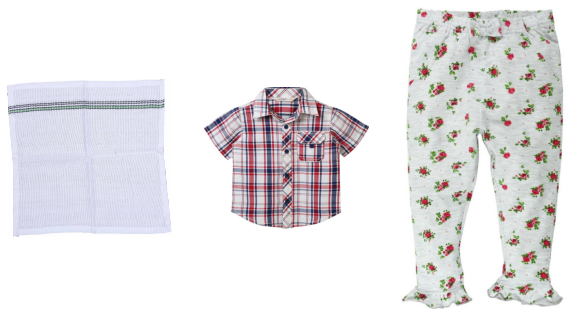

--------------------------------------


In [289]:
# Affichage d'exemples pour chaque catégorie
def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

for name in data.label_name.unique() :
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
    print("--------------------------------------")

## Test de l'algorithme ORB pour extraire les features

Exemple sur une image

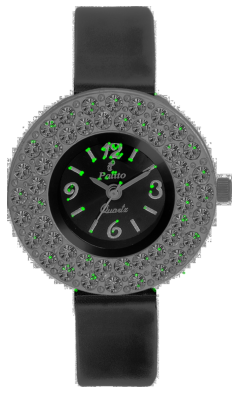

Descripteurs :  (256, 32)
256
[[ 56  26  78 ... 165 238 115]
 [163 177  96 ... 142 222 223]
 [114  23  14 ... 100 182  83]
 ...
 [ 56 184 233 ... 139  86 250]
 [213 125  15 ... 115  38  74]
 [ 84  97  83 ... 179   7 162]]


In [291]:
orb = cv.ORB_create(nfeatures=256)
img = cv.imread(path+list_photos[0],0) # convert in gray
img = cv.equalizeHist(img)   # equalize image histogram

# find the keypoints with ORB
kp = orb.detect(img,None)

# compute the descriptors with ORB
kp, des = orb.compute(img, kp)

# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2)
plt.axis('off')
plt.show()
print("Descripteurs : ", des.shape)
print(len(kp))
print(des)


Extraction des features pour chaque image

In [292]:
# identification of key points and associated descriptors
orb_keypoints = []
temps1=time.time()
orb = cv.ORB_create(nfeatures=128)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv.equalizeHist(image)   # equalize image histogram
    kp, des = orb.detectAndCompute(res, None)
    orb_keypoints.append(des)

orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", orb_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (133834, 32)
temps de traitement ORB descriptor :            86.09 secondes


C:\Users\BENAVEN\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Création des clusters de features (Bag of Visual Words)

In [293]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

#k = 200
k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering (Using MiniBatchKMeans for speed of treatment)
kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  366
Création de 366 clusters de descripteurs ...
temps de traitement kmeans :            11.41 secondes


Création des histogrammes pour chaque image

In [294]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.93 secondes


Réduction de dimension en conservant 95% de la variance

In [295]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.95)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

df_pca = pd.DataFrame(feat_pca[:,0:2], columns=['tsne1', 'tsne2'])
df_pca["class"] = data["label_name"]

Dimensions dataset avant réduction PCA :  (1050, 366)
Dimensions dataset après réduction PCA :  (1050, 262)


Visualisation via TSNE des features images

In [296]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(im_features)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

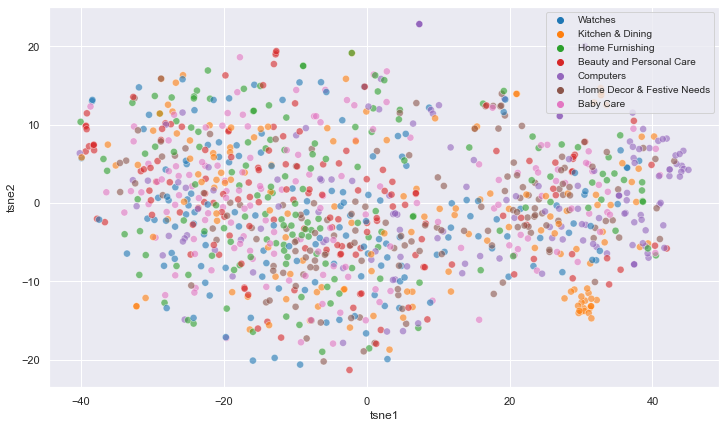

In [297]:
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.legend(prop={'size': 10}) 

plt.show()

## Clustering et Random Forest des features images

In [298]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(im_features)
metrics.adjusted_rand_score(data['label_name'], kmeans.labels_)

0.022747849478766

In [192]:
X_train,X_test,y_train,y_test=train_test_split(im_features,data['label_name'],test_size=0.3, random_state=0)

In [195]:
model_gs = GridSearchCV(estimator = RandomForestClassifier(random_state=0, n_estimators = 500), param_grid={'max_depth': range(9,35,2)}, cv=5)      # définition de la Cross-Validation
        
model_gs.fit(X_train, y_train) #Fit du modèle sur le jeu d'entrainement
print('Score :', model_gs.score(X_test,y_test))
print('Paramètres : ', model_gs.best_params_)   # Détermination des meilleurs paramètres

Score : 0.3238095238095238
Paramètres :  {'max_depth': 21}


# Feature extraction

In [7]:
from tensorflow.keras.applications import EfficientNetB0

In [8]:
# Import du modèle préentrainé sans la couche top
model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')

Un nombre inférieur d'image est gardé pour cette analyse, afin de ne pas surcharger la machine.
100 images de chaque catégorie sont conservées. L'extraction de leur features est traitée séparément en 2 groupes de 50 images.

In [14]:
n = 50
data_fe = data.groupby('label_name').apply(lambda x: x.sample(n))
data_fe.index = data_fe.index.droplevel(0)

In [17]:
data_fe_2 = data.drop(data_fe.index).groupby('label_name').apply(lambda x: x.sample(n))
data_fe_2.index = data_fe_2.index.droplevel(0)

In [19]:
features_list = []
for i, im in enumerate(data_fe['image_path'].tolist()):
    if i%50 == 0 :
        print(i)        
    im_path = os.path.join(path, im)
    im_arr = cv.imread(im_path)
    im_feat = model(im_arr).numpy()[0]
    features_list.append((im, im_feat))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340


In [20]:
features_list_2 = []
for i, im in enumerate(data_fe_2['image_path'].tolist()):
    if i%50 == 0 :
        print(i)        
    im_path = os.path.join(path, im)
    im_arr = cv.imread(im_path)
    im_feat = model(im_arr).numpy()[0]
    features_list_2.append((im, im_feat))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340


In [21]:
features1 = [feat[1] for feat in features_list]
features2 = [feat[1] for feat in features_list_2]
features = np.concatenate((features1,features2),axis=0)
labels_name = np.concatenate((data_fe['label_name'],data_fe_2['label_name']))

Visualisation via TSNE

In [22]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(features)

C:\Users\BENAVEN\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


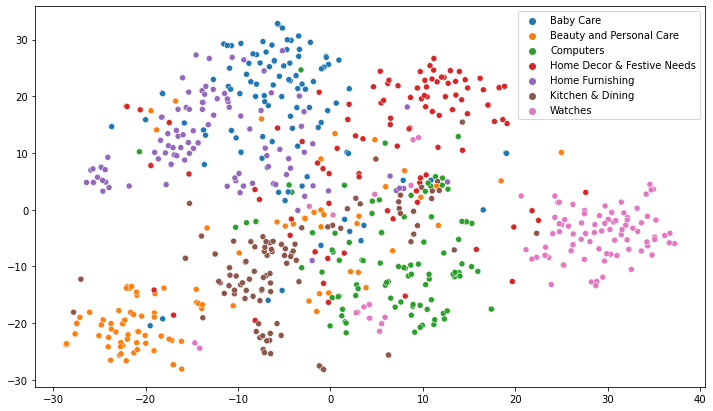

In [23]:
plt.figure(figsize=(12,7))
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=labels_name); 

### Clustering et Random Forest

In [26]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(features)
metrics.adjusted_rand_score(labels_name, kmeans.labels_)

0.39801608496810725

In [250]:
X_train, X_test, y_train_fe, y_test_fe = train_test_split(features, labels_name, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [235]:
params = {'max_depth': range(5,31,2)}
model = RandomForestClassifier(random_state=0, n_estimators = 500);
model_gs_img = GridSearchCV(model, params);
model_gs_img.fit(X_train_std, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=500, random_state=0),
             param_grid={'max_depth': range(5, 31, 2)})

In [236]:
print(model_gs_img.best_params_)
print(model_gs_img.score(X_test_std, y_test))

{'max_depth': 11}
0.7857142857142857


# Fusion texte/image

### 1er test : Concaténation des features texte et image puis ACP

In [331]:
indexs = pd.concat([data_fe,data_fe_2]).index.values

In [332]:
txt_data = pd.DataFrame(X_clean_tf_pca).iloc[indexs,:].values
img_data = features
labels = labels_name

In [333]:
data = np.concatenate((txt_data,img_data),axis=1)

In [342]:
pca = decomposition.PCA(n_components=0.9)
data_pca = pca.fit_transform(data)

In [343]:
np.shape(data_pca)

(700, 159)

In [344]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(data_pca)

C:\Users\BENAVEN\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


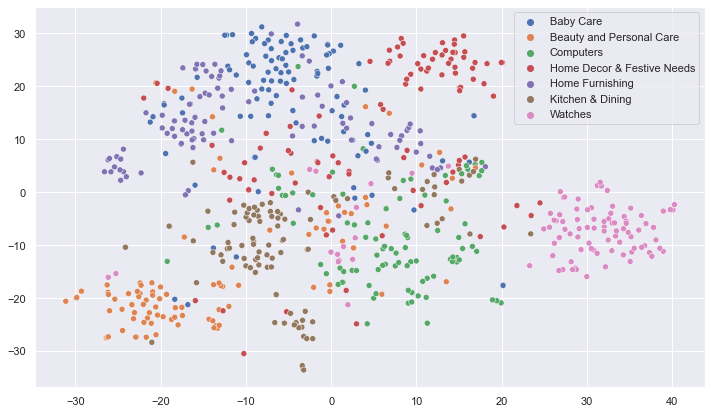

In [345]:
plt.figure(figsize=(12,7))
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=labels); 

In [346]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(data_pca)
metrics.adjusted_rand_score(labels, kmeans.labels_)

0.39705593852557086

In [357]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=0)

In [358]:
params = {'max_depth': range(5,31,2)}
model = RandomForestClassifier(random_state=0, n_estimators = 500);
clf = GridSearchCV(model, params);
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=500, random_state=0),
             param_grid={'max_depth': range(5, 31, 2)})

In [359]:
print(clf.best_params_)
print(clf.score(X_test, y_test))

{'max_depth': 11}
0.780952380952381


### 2è test : ACP séparément sur variables texte et image puis concaténation

In [347]:
txt_pca = pca.fit_transform(txt_data)
img_pca = pca.fit_transform(img_data)
data_pca_bf = np.concatenate((txt_pca,img_pca),axis=1)

In [348]:
np.shape(data_pca_bf)

(700, 599)

In [349]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(data_pca_bf)

C:\Users\BENAVEN\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


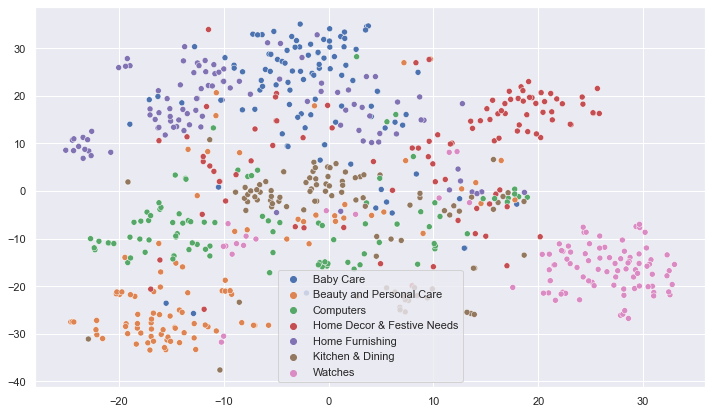

In [350]:
plt.figure(figsize=(12,7))
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=labels); 

In [351]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(data_pca_bf)
metrics.adjusted_rand_score(labels, kmeans.labels_)

0.4066610839800699

In [355]:
X_train, X_test = train_test_split(data_pca_bf, test_size=0.3, random_state=0)
params = {'max_depth': range(5,31,2)}
model = RandomForestClassifier(random_state=0, n_estimators = 500);
clf = GridSearchCV(model, params);
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=500, random_state=0),
             param_grid={'max_depth': range(5, 31, 2)})

In [356]:
print(clf.best_params_)
print(clf.score(X_test, y_test))

{'max_depth': 9}
0.7380952380952381


### 3è test (Non supervisé) : Calcul des distances de chaque individu aux centroides pour les features txt et images puis CLustering sur ces distances

In [80]:
kmeans = KMeans(n_clusters=7, random_state=0)
txt_dist=kmeans.fit_transform(txt_pca)

In [83]:
kmeans = KMeans(n_clusters=7, random_state=0)
img_dist=kmeans.fit_transform(img_pca)

In [84]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(np.concatenate((txt_dist,img_dist),axis=1))
metrics.adjusted_rand_score(labels, kmeans.labels_)

0.11904547350899078

### 4è test (Supervisé) : Calcul des probabilités de chaque individu d'appartenir à une catégorie puis Random Forest sur ces probabilités

In [94]:
X_train, X_test = train_test_split(txt_data, test_size=0.3, random_state=0)
params = {'max_depth': range(5,31,2)}
model = RandomForestClassifier(random_state=0, n_estimators = 500);
clf = GridSearchCV(model, params);
clf.fit(X_train, y_train)
txt_proba = clf.predict_proba(X_test)

In [95]:
X_train, X_test = train_test_split(img_data, test_size=0.3, random_state=0)
params = {'max_depth': range(5,31,2)}
model = RandomForestClassifier(random_state=0, n_estimators = 500);
clf = GridSearchCV(model, params);
clf.fit(X_train, y_train)
img_proba = clf.predict_proba(X_test)

In [270]:
txt_pca_train, txt_pca_test = train_test_split(txt_pca, test_size=0.3, random_state=0)

In [262]:
txt_train, txt_test = train_test_split(txt_data, test_size=0.3, random_state=0)

In [231]:
X_train, X_test= train_test_split(np.concatenate((txt_proba,img_proba),axis=1), test_size=0.3, random_state=0)
params = {'max_depth': range(5,31,2)}
model = RandomForestClassifier(random_state=0, n_estimators = 500);
clf = GridSearchCV(model, params);
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=500, random_state=0),
             param_grid={'max_depth': range(5, 31, 2)})

In [232]:
print(clf.best_params_)
print(clf.score(X_test, y_test))

{'max_depth': 9}
0.7301587301587301


### 5è test (supervisé) : Concaténation des features texte et des probabilités image

In [276]:
X_train, X_test, y_train,y_test = train_test_split(np.concatenate((txt_pca_test,img_proba),axis=1),y_test_fe, test_size=0.3, random_state=0)
params = {'max_depth': range(5,31,2)}
model = RandomForestClassifier(random_state=0, n_estimators = 500);
clf = GridSearchCV(model, params);
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=500, random_state=0),
             param_grid={'max_depth': range(5, 31, 2)})

In [277]:
print(clf.best_params_)
print(clf.score(X_test, y_test))

{'max_depth': 7}
0.746031746031746


# Analyse d'erreurs (sur modèle supervisé)

In [365]:
y_true = y_test
y_pred_rf = model_gs_tf.predict(X_tf_test)
cm_rf = metrics.confusion_matrix(y_true, y_pred_rf, normalize = 'true', labels = label_test)

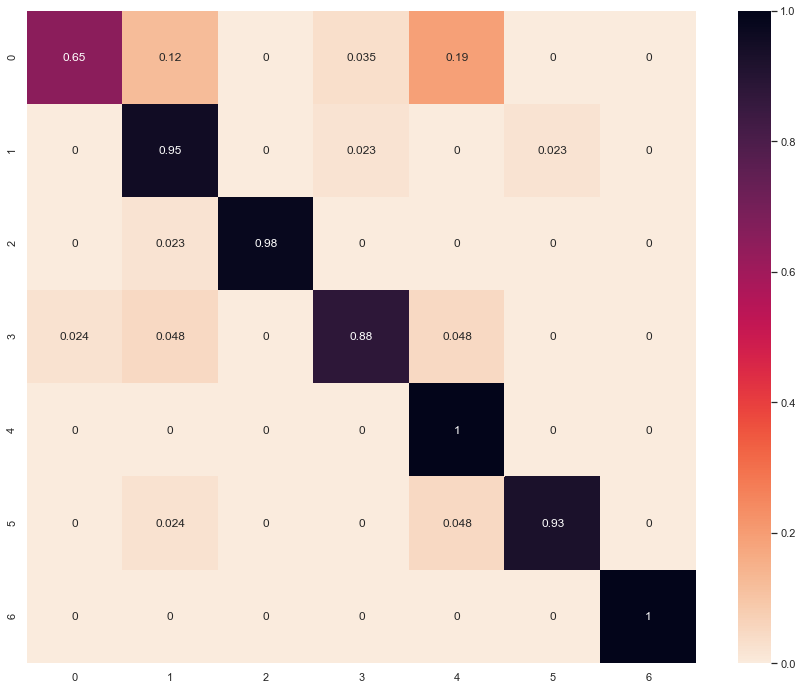

In [368]:
plt.figure(figsize=(15,12))
sns.heatmap(cm_rf, annot=True, cmap = 'rocket_r');

In [369]:
y_true = y_test_fe
y_pred_rf = model_gs_img.predict(X_test_std)
cm_rf_img = metrics.confusion_matrix(y_true, y_pred_rf, normalize = 'true', labels = label_test)

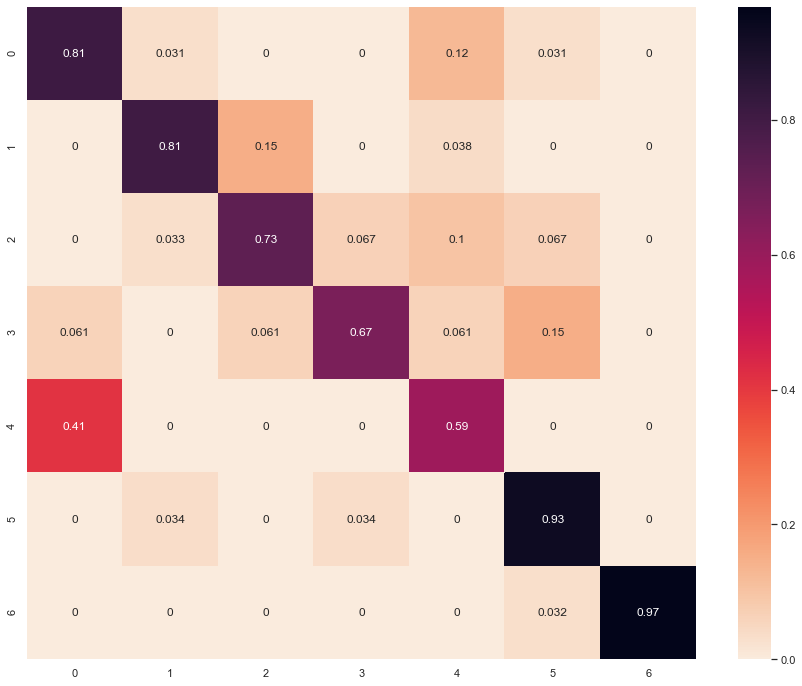

In [371]:
plt.figure(figsize=(15,12))
sns.heatmap(cm_rf_img, annot=True, cmap = 'rocket_r');

In [372]:
label_test = ['Baby Care','Beauty and Personal Care','Computers','Home Decor & Festive Needs','Home Furnishing','Kitchen & Dining','Watches']

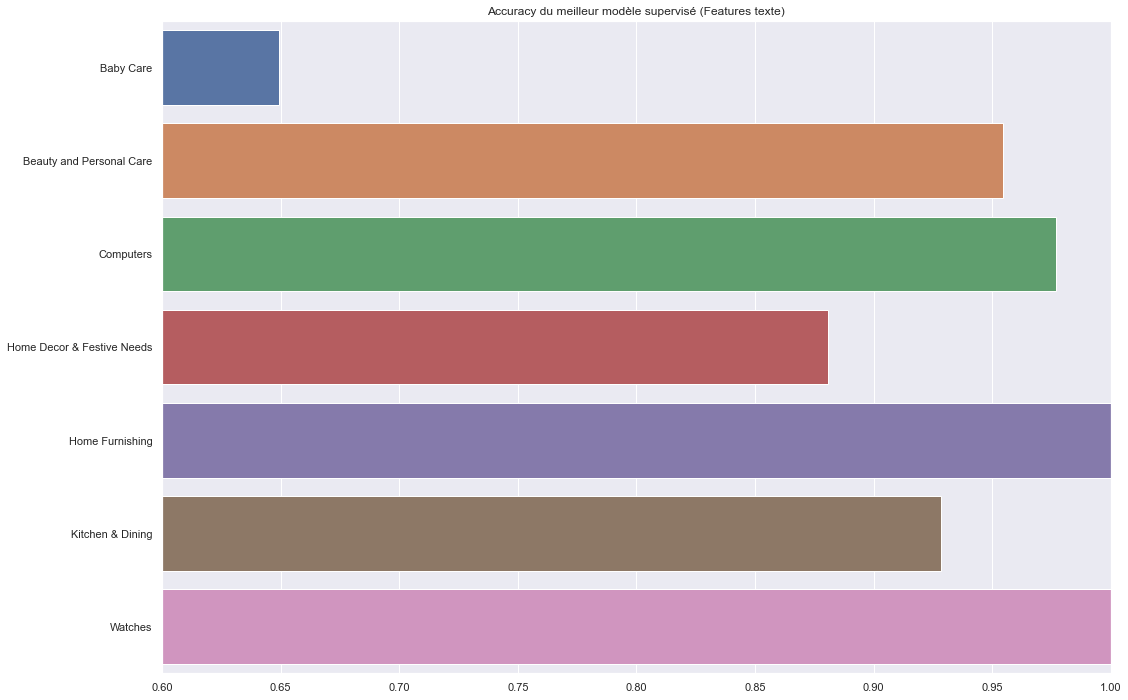

In [374]:
sns.set(rc={'figure.figsize':(17,12),'xtick.labelsize': 14,'ytick.labelsize': 14})
g=sns.barplot(y=label_test,x=cm_rf.diagonal())
g.set_xlim([0.5,1])
g.set(title='Accuracy du meilleur modèle supervisé (Features texte)',fontsize=20);

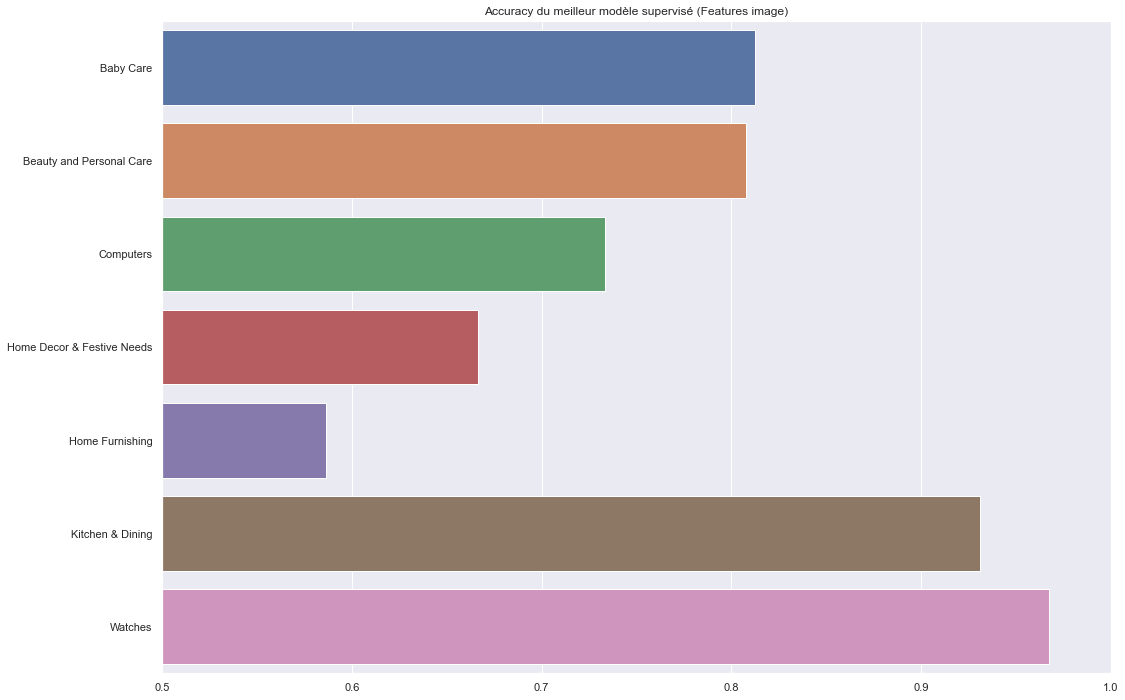

In [375]:
sns.set(rc={'figure.figsize':(17,12),'xtick.labelsize': 14,'ytick.labelsize': 14})
g=sns.barplot(y=label_test,x=cm_rf_img.diagonal())
g.set_xlim([0.5,1])
g.set(title='Accuracy du meilleur modèle supervisé (Features image)',fontsize=20);